In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Load the dataset
df = pd.read_csv('../hardware_monitor_data.csv')

# Dropping these columns becuase I don't know how to impute these features as they have 90 percent of missing values.
df = df.drop(['cpu_temperature', 'cpu_power'], axis='columns')

# Normalize the 'cpu_load' column
scaler = MinMaxScaler()
df['cpu_load'] = scaler.fit_transform(df[['cpu_load']])

# Convert data to sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

SEQ_LENGTH = 30
cpu_load = df['cpu_load'].values
sequences = create_sequences(cpu_load, SEQ_LENGTH)

# Split into train and test sets
train_data, test_data = train_test_split(sequences, test_size=0.2, random_state=42)
print(train_data.shape)
# Convert data to PyTorch tensors
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out
# Initialize the model
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1
NUM_LAYERS = 1

model = RNNModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
EPOCHS = 10
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch+1}/{EPOCHS}]") as progress_bar:
        for batch in progress_bar:
            inputs = batch[:, :-1].unsqueeze(-1)  # Input sequences
            targets = batch[:, -1].unsqueeze(-1)  # Target values
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Update epoch loss
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=(epoch_loss / len(train_loader)))

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss / len(train_loader):.4f}")
torch.save(model,'./rnn_cpu_load.pth')


(57576, 30)


Epoch [1/10]: 100%|██████████| 900/900 [00:04<00:00, 212.18batch/s, loss=0.0006]  


Epoch [1/10], Loss: 0.0006


Epoch [2/10]: 100%|██████████| 900/900 [00:04<00:00, 222.41batch/s, loss=0.000153]


Epoch [2/10], Loss: 0.0002


Epoch [3/10]: 100%|██████████| 900/900 [00:04<00:00, 222.24batch/s, loss=0.000133]


Epoch [3/10], Loss: 0.0001


Epoch [4/10]: 100%|██████████| 900/900 [00:04<00:00, 210.51batch/s, loss=0.000125]


Epoch [4/10], Loss: 0.0001


Epoch [5/10]: 100%|██████████| 900/900 [00:04<00:00, 224.40batch/s, loss=0.000126]


Epoch [5/10], Loss: 0.0001


Epoch [6/10]: 100%|██████████| 900/900 [00:04<00:00, 221.05batch/s, loss=0.000124]


Epoch [6/10], Loss: 0.0001


Epoch [7/10]: 100%|██████████| 900/900 [00:04<00:00, 204.44batch/s, loss=0.000124]


Epoch [7/10], Loss: 0.0001


Epoch [8/10]: 100%|██████████| 900/900 [00:04<00:00, 211.00batch/s, loss=0.000125]


Epoch [8/10], Loss: 0.0001


Epoch [9/10]: 100%|██████████| 900/900 [00:04<00:00, 204.99batch/s, loss=0.000124]


Epoch [9/10], Loss: 0.0001


Epoch [10/10]: 100%|██████████| 900/900 [00:04<00:00, 209.50batch/s, loss=0.000123]

Epoch [10/10], Loss: 0.0001


C:\Users\vishw\AppData\Local\Temp\ipykernel_19584\352051468.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./rnn_cpu_load.pth')


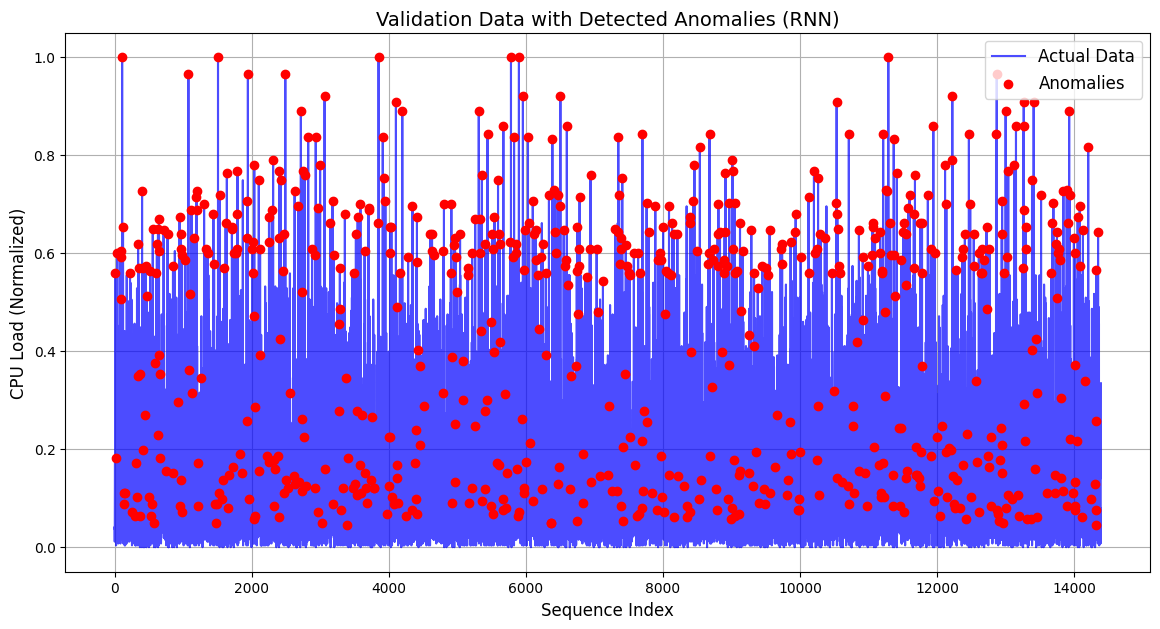

Threshold for anomalies: 0.005417576432228082
Number of anomalies detected: 720


In [11]:
import matplotlib.pyplot as plt

# Evaluate the model and detect anomalies
model = torch.load('./rnn_cpu_load.pth')
model.eval()

test_inputs = test_data[:, :-1].unsqueeze(-1)  # Input sequences
test_targets = test_data[:, -1].unsqueeze(-1)  # True values for the last step

# Predictions
with torch.no_grad():
    predictions = model(test_inputs)

# Compute reconstruction error
reconstruction_error = torch.abs(predictions - test_targets).numpy()

# Set a threshold for anomalies (e.g., 95th percentile of reconstruction error)
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

# Convert data to numpy for plotting
test_indices = np.arange(len(test_targets))
test_targets_np = test_targets.numpy().flatten()
predictions_np = predictions.numpy().flatten()

# Identify anomalies for plotting
anomaly_indices = test_indices[anomalies.flatten()]
anomaly_values = test_targets_np[anomalies.flatten()]

# Plot test data, predictions, and anomalies
plt.figure(figsize=(14, 7))

# Plot actual data
plt.plot(test_indices, test_targets_np, label="Actual Data", color="blue", alpha=0.7)

# Plot predictions
# plt.plot(test_indices, predictions_np, label="Predictions", color="green", linestyle="--", alpha=0.7)

# Highlight anomalies
plt.scatter(anomaly_indices, anomaly_values, color="red", label="Anomalies", zorder=3)

# Add labels, title, and legend
plt.title("Validation Data with Detected Anomalies (RNN)", fontsize=14)
plt.xlabel("Sequence Index", fontsize=12)
plt.ylabel("CPU Load (Normalized)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Additional information
print(f"Threshold for anomalies: {threshold}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")
